In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"#"2"

In [2]:
# import estimator class
from kalmanEstimator import KalmanEstimator

from myUtils.sequences_treatment import *

# import environment class
from optimalIntermittency import OptimalIntermittency

# import deer classes
from deer.learning_algos.q_net_keras import MyQNetwork
from deer.agent import NeuralAgent
import deer.experiment.base_controllers as bc


Using TensorFlow backend.


In [3]:
# construct estimator
est=KalmanEstimator()

In [4]:
# generate sequences
numberSamples=6
T=10

(objectives,observations)=est.generateSequence(T,numberSamples=numberSamples)

print('shape objectives:',np.shape(objectives))
print('shape observations:',np.shape(observations))

shape objectives: (6, 10, 1)
shape observations: (6, 10, 1)


In [5]:
# load the RL policy (used for training)
rng=np.random.RandomState(123456)
env=OptimalIntermittency(est,objectives,observations,rng)
qnetwork=MyQNetwork(environment=env,random_state=rng)
agent=NeuralAgent(env,qnetwork,random_state=rng)

# load agent
#agent.setNetwork('../../myFolder/myModels/retrainedAgent_KF')

# --- Bind controllers to the agent ---
# Before every training epoch, we want to print a summary of the agent's epsilon, discount and 
# learning rate as well as the training epoch number.
agent.attach(bc.VerboseController())

# During training epochs, we want to train the agent after every action it takes.
# Plus, we also want to display after each training episode (!= than after every training) the average bellman
# residual and the average of the V values obtained during the last episode.
agent.attach(bc.TrainerController())

# All previous controllers control the agent during the epochs it goes through. However, we want to interleave a 
# "test epoch" between each training epoch ("one of two epochs", hence the periodicity=2). We do not want these 
# test epoch to interfere with the training of the agent, which is well established by the TrainerController, 
# EpsilonController and alike. Therefore, we will disable these controllers for the whole duration of the test 
# epochs interleaved this way, using the controllersToDisable argument of the InterleavedTestEpochController. 
# The value of this argument is a list of the indexes of all controllers to disable, their index reflecting in 
# which order they were added. Here, "0" is refering to the firstly attached controller, thus the 
# VerboseController; "2" refers to the thirdly attached controller, thus the LearningRateController; etc. The order 
# in which the indexes are listed is not important.
# For each test epoch, we want also to display the sum of all rewards obtained, hence the showScore=True.
# Finally, we want to call the summarizePerformance method of Toy_Env every [summarize_every] *test* epochs.
agent.attach(bc.InterleavedTestEpochController(
    id=0,
    epoch_length=T,
    controllers_to_disable=[1],
    periodicity=2,
    show_score=True,
    summarize_every=1))

print('Agent constructed')

Environment parameters
  PENALIZATION= 0
  sigmaMEMORY= 5
  observationsMEMORY= 5
Sequences parameters
  outOfRangeValue= -1
  numerSamples= 6
  T= 10
  n_dim_obj= 1
  n_dim_obs= 1
Agent constructed


In [6]:
# Train the RL agent
agent.run(n_epochs=20, epoch_length=T)
print('Agent Trained')

Average (on the epoch) training loss: 5.023469924926758
Episode average V value: -2.58003568649292
epoch 1:
Learning rate: 0.005
Discount factor: 0.9
Epsilon: 0.1
epoch 2:
Learning rate: 0.005
Discount factor: 0.9
Epsilon: 0.1
Testing score per episode (id: 0) is -41.47822169693309 (average over 1 episode(s))
np.shape(sigma): (10,)
np.shape(obserbations_c: (10, 1)
Summary Perf. Num measurements: 7 - Num actions: 10 - Mean sigma: 0.7
Average (on the epoch) training loss: 2.1501376628875732
Episode average V value: 0.837388257185618
epoch 3:
Learning rate: 0.005
Discount factor: 0.9
Epsilon: 0.1
epoch 4:
Learning rate: 0.005
Discount factor: 0.9
Epsilon: 0.1
Testing score per episode (id: 0) is -3.2292763886436573 (average over 1 episode(s))
np.shape(sigma): (10,)
np.shape(obserbations_c: (10, 1)
Summary Perf. Num measurements: 10 - Num actions: 10 - Mean sigma: 1.0
Average (on the epoch) training loss: 1.3237638473510742
Episode average V value: 1.2567752838134765
epoch 5:
Learning rate

In [7]:
# CORRUPT observations according to the agent policy
(sigma,observations_corrupted_outOfRange)=corruptSequenceWithAgentPolicy(agent,observations)
observations_corrupted_mask=corruptSequence_mask(observations,sigma)

estimated_obj=est.estimateAll(observations_corrupted_mask)

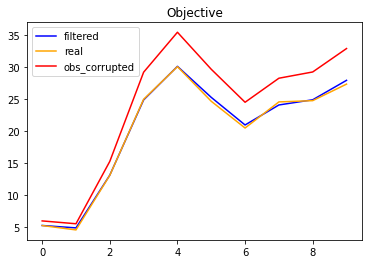

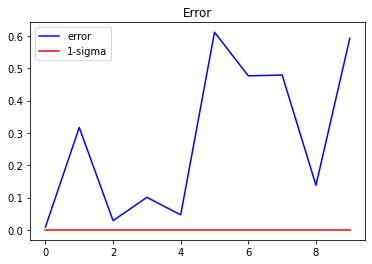

In [8]:
# plot
ind_sample=2
pyplot.title('Objective')
pyplot.plot(estimated_obj[ind_sample,:], color='blue', label='filtered')
pyplot.plot(objectives[ind_sample,:], color='orange', label='real')
pyplot.plot(observations_corrupted_mask[ind_sample,:], color='red', label='obs_corrupted')
pyplot.legend()
pyplot.show()

absError=abs(objectives-estimated_obj)

pyplot.title('Error')
pyplot.plot(absError[ind_sample,:], color='blue', label='error')
pyplot.plot(max(absError[ind_sample,:])*(1-sigma[ind_sample,:]), color='red', label='1-sigma')
pyplot.legend()
pyplot.show()